tau:  0.8  semilla:  0  arreglo:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]  Mejor solucion factible:  1428  de:  1428
tau:  0.8  semilla:  1  arreglo:  [0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0]  Mejor solucion factible:  1428  de:  1428
tau:  0.8  semilla:  2  arreglo:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]  Mejor solucion factible:  1428  de:  1428
tau:  0.8  semilla:  3  arreglo:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]  Mejor solucion factible:  1428  de:  1428
tau:  0.8  semilla:  4  arreglo:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]  Mejor solucion factible:  1428  de:  1428
tau:  0.8  semilla:  5  arreglo:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]  Mejor solucion factible:  1428  de:  1428
tau:  0.8  semilla:  6  arreglo:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]  Mejor solucion factible:  1428  de:  1428
tau:  0.8  semilla:  7  arreglo:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]  Mejor solucion factible:  1428  de:  1428
tau:  0.8  semilla:  8  arreglo:  [0 0 0 0 0 0 0

c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='tau', ylabel='mejor_solucion'>

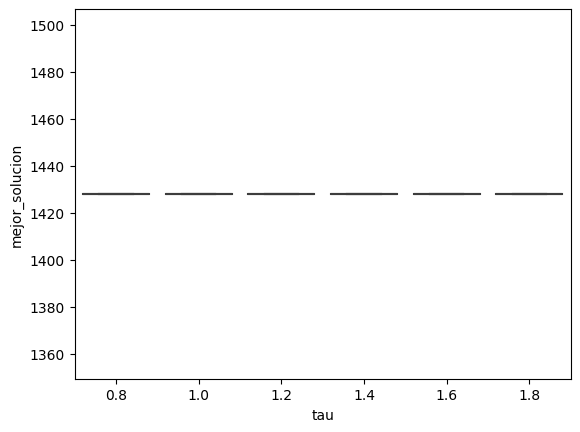

In [10]:

%pip install pandas
%pip install numpy
%pip install time
%pip install sys
%pip install seaborn

import sys
import time
import numpy as np
import seaborn as sns
import pandas as pd

def leer_archivo_csv(nombre_archivo):
    casos = []
    with open(nombre_archivo, 'r') as archivo:
        lineas = archivo.readlines()

        i = 0
        while i < len(lineas):
            # Buscar el nombre del caso
            while i < len(lineas) and not lineas[i].strip().startswith("knap"):
                i += 1

            if i >= len(lineas):
                break

            nombre_caso = lineas[i].strip()
            i += 1  # Avanzar a la siguiente línea

            # Leer el resto de la información del caso
            n = int(lineas[i].split()[1])
            c = int(lineas[i + 1].split()[1])
            z = int(lineas[i + 2].split()[1])
            tiempo = float(lineas[i + 3].split()[1])

            datos_caso = np.zeros((n, 4), dtype=int)

            for j in range(n):
                datos = list(map(int, lineas[i + 4 + j].split(',')))
                datos_caso[j, :] = datos

            casos.append({
                'nombre': nombre_caso,
                'n': n,
                'c': c,
                'z': z,
                'tiempo': tiempo,
                'datos': datos_caso
            })

            # Buscar el próximo separador "-----"
            while i < len(lineas) and not lineas[i].strip().startswith("-----"):
                i += 1

            i += 1  # Avanzar a la siguiente línea después de "-----"

    return casos

def solucion_inicial(n, datos_caso, capacidad):
    # Generar una solución inicial factible
    x = np.zeros(n, dtype=int)
    for i in np.argsort(-datos_caso[:, 1] / datos_caso[:, 2]):  # Ordenar los objetos por la relación precio/peso
        if datos_caso[i, 1] <= capacidad:
            x[i] = 1
            capacidad -= datos_caso[i, 1]
    return x

def generar_probabilidades(n, tau):
    # Generar probabilidades según la ecuación 1 con ruleta
    probabilidades = np.array([(i + 1) ** -tau for i in range(n)])
    probabilidades /= np.sum(probabilidades)  # Normalizar
    return probabilidades

def seleccionar_componente(probabilidades):
    # Seleccionar componente basado en las probabilidades (ruleta)
    seleccionado = np.random.choice(len(probabilidades), p=probabilidades)
    return seleccionado

def evaluar_solucion(solucion, datos_caso):
    # Calcular la evaluación de la solución según la función objetivo
    # Maximizar la sumatoria vi * xi
    evaluacion = np.sum(solucion * datos_caso[:, 1])  
    return evaluacion

def generar_nueva_solucion(solucion, componente_seleccionado, datos_caso, capacidad):
    nueva_solucion = solucion.copy()
    nueva_solucion[componente_seleccionado] = 1 - nueva_solucion[componente_seleccionado]

    # Ajustar la solución para cumplir con la capacidad
    while np.sum(nueva_solucion * datos_caso[:, 2]) > capacidad:
        # Encontrar el objeto con el menor valor que esté incluido en la solución
        objetos_incluidos = np.where(nueva_solucion == 1)[0]
        
        if len(objetos_incluidos) == 0:
            # No hay objetos incluidos, no se puede ajustar más
            break

        objeto_a_quitar = objetos_incluidos[np.argmin(datos_caso[objetos_incluidos, 1])]
        
        # Excluir el objeto de la solución
        nueva_solucion[objeto_a_quitar] = 0

    return nueva_solucion



def algoritmo(caso, num_iteraciones, tau):
    mejor_solucion = solucion_inicial(caso['n'], caso['datos'], caso['c'])
    mejor_evaluacion = evaluar_solucion(mejor_solucion, caso['datos'])

    for e in range(num_iteraciones):
        #Generar probabilidades
        probabilidades = generar_probabilidades(caso['n'], tau)

        # Evaluar y ordenar solución actual
        fitness = [evaluar_solucion(mejor_solucion, caso['datos']) for a in range(caso['n'])]
        indices_ordenados = np.argsort(fitness)[::-1]

        for i in range(caso['n']):
            #Seleccionar componente con ruleta
            componente_seleccionado = seleccionar_componente(probabilidades)

            #Generar nueva solución
            nueva_solucion = generar_nueva_solucion(mejor_solucion, componente_seleccionado, caso['datos'], caso['c'])

            #Evaluar la nueva solución
            nueva_evaluacion = evaluar_solucion(nueva_solucion, caso['datos'])

            # Actualizar la mejor solución si es necesario
            if nueva_evaluacion > mejor_evaluacion and np.sum(nueva_solucion * caso['datos'][:, 2]) <= caso['c']:
                mejor_solucion = nueva_solucion
                mejor_evaluacion = nueva_evaluacion

    return mejor_solucion, mejor_evaluacion


tau_values = [0.8, 1, 1.2, 1.4, 1.6, 1.8]
iteraciones = 1000
archivo_csv = 'knapPI_11_20_1000.csv'
semillas = 30
caso = 1
casos = leer_archivo_csv(archivo_csv)

#Crear un DataFrame para almacenar los resultados
df = pd.DataFrame()

for tau in tau_values:
    valores = list()
    for semilla in range(semillas):
        np.random.seed(semilla)
        array, mejor_solucion = algoritmo(casos[caso-1], iteraciones, tau)
        print("tau: ", tau, " semilla: ", semilla, " arreglo: ", array, " Mejor solucion factible: ", mejor_solucion, " de: ", casos[caso-1]['z'])
        valores.append(mejor_solucion)
    
    df_temp = pd.DataFrame(valores, columns=['mejor_solucion'])
    df_temp['tau'] = tau
    df = pd.concat([df, df_temp])

# Crear el boxplot para cada taau
sns.boxplot(x='tau', y='mejor_solucion', data=df)



